In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports and Settings

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from pathlib import Path
import keras
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

np.random.seed(42)
tf.random.set_seed(1234)

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [ ]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

## Model Run Directory


In [ ]:
experiment = 0

In [ ]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

hdf_store = results_path / 'TimeSeriesGAN.h5'

# Load Data

In [ ]:
data_path = '/content/drive/MyDrive/BBG Capstone Summer 2023/Data/timegan_data_all.csv'
df = pd.read_csv(data_path)
df['Dates'] = pd.to_datetime(df['Unnamed: 1'], infer_datetime_format=True)
df.set_index(zip(df['Unnamed: 0'], df['Dates']), inplace=True)
df.drop(columns = ['Unnamed: 0','Unnamed: 1' ,'Dates'], inplace = True)
df

CUR_RATIO  QUICK_RATIO  INTEREST_COVERAGE_RATIO  \
VZ UN Equity  2015-03-31     0.7953       0.6140                   5.7556   
              2015-06-30     0.7016       0.5469                   5.6756   
              2015-09-30     0.6311       0.5012                   5.4365   
              2015-12-31     0.6378       0.5214                   7.1805   
              2016-03-31     0.7089       0.5503                   5.8569   
...                             ...          ...                      ...   
LYB UN Equity 2022-03-31     1.7630       0.9122                  22.4459   
              2022-06-30     1.6784       0.8108                  36.9138   
              2022-09-30     1.6149       0.7374                  11.6000   
              2022-12-31     1.7522       0.8200                   5.7294   
              2023-03-31     1.8462       0.8452                   6.1466   

                          TOT_DEBT_TO_TOT_EQY  TOT_DEBT_TO_TOT_CAP  \
VZ UN Equity  2015-03-31            1053.8898              91.3337   
              2015-06-30             882.9501              89.8265   
              2015-09-30             772.4109              88.5375   
              2015-12-31             615.0039              86.0141   
              2016-03-31             546.5851              84.5341   
...                                       ...                  ...   
LYB UN Equity 2022-03-31             100.8263              50.2057   
              2022-06-30             105.5340              51.3462   
              2022-09-30             104.1481              51.0159   
              2022-12-31             103.3901              50.8334   
              2023-03-31             100.2646              50.0661   

                          ASSET_TURNOVER  MODIFIED_WORK_CAP_TURN  IS_EPS  \
VZ UN Equity  2015-03-31          0.5608                  9.5755    1.03   
              2015-06-30          0.5546                  9.0099    1.04   
              2015-09-30          0.5575                  9.0311    0.99   
              2015-12-31          0.5521                 14.1855    1.32   
              2016-03-31          0.5488                  9.6206    1.06   
...                                  ...                     ...     ...   
LYB UN Equity 2022-03-31          1.3654                  8.6949    4.01   
              2022-06-30          1.4411                  8.3764    5.00   
              2022-09-30          1.4125                  8.6406    1.75   
              2022-12-31          1.3802                  9.0935    1.07   
              2023-03-31          1.2830                  8.1427    1.45   

                          PX_TO_BOOK_RATIO  PE_RATIO  ...  \
VZ UN Equity  2015-03-31           21.2375   10.4682  ...   
              2015-06-30           16.6011    9.7510  ...   
              2015-09-30           13.4752    8.8216  ...   
              2015-12-31           11.4598   11.6028  ...   
              2016-03-31           11.8258   13.8028  ...   
...                                    ...       ...  ...   
LYB UN Equity 2022-03-31            2.6530    5.3216  ...   
              2022-06-30            2.3402    4.7556  ...   
              2022-09-30            2.0107    4.9836  ...   
              2022-12-31            2.1439    6.6654  ...   
              2023-03-31            2.4022    8.5658  ...   

                          USD:CNY Exchange Rate  Fed Funds Target Rate  \
VZ UN Equity  2015-03-31                 6.1997                   0.25   
              2015-06-30                 6.2010                   0.25   
              2015-09-30                 6.3561                   0.25   
              2015-12-31                 6.4937                   0.50   
              2016-03-31                 6.4536                   0.50   
...                                         ...                    ...   
LYB UN Equity 2022-03-31                 6.3400                   0.50   
              2022-06-

## Details

In [ ]:
stocks = df.index.get_level_values(0).unique()
n_stocks = len(stocks)
total_timesteps = len(df.loc[stocks[0], :])
n_cat = 1
n_seq = len(df.columns) - n_cat


print(f'No. of stocks = {n_stocks}\nTotal timesteps per stock = {total_timesteps}\nNumber of Sequences = {n_seq}\nNo. of classifications : {n_cat}')

No. of stocks = 178
Total timesteps per stock = 33
Number of Sequences = 38
No. of classifications : 1


In [ ]:
industry_cat = np.unique(df['industry'].values)
industry_cat

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

## Preprocessing

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.iloc[:, :n_seq]).astype(np.float32)
df.iloc[:, :n_seq] = pd.DataFrame(scaled_data, index = df.index, columns= df.columns[:n_seq])

In [ ]:
df.head()

CUR_RATIO  QUICK_RATIO  INTEREST_COVERAGE_RATIO  \
VZ UN Equity 2015-03-31   0.050250     0.050268                 0.223770   
             2015-06-30   0.043026     0.044232                 0.223741   
             2015-09-30   0.037591     0.040121                 0.223654   
             2015-12-31   0.038108     0.041938                 0.224288   
             2016-03-31   0.043589     0.044537                 0.223807   

                         TOT_DEBT_TO_TOT_EQY  TOT_DEBT_TO_TOT_CAP  \
VZ UN Equity 2015-03-31             0.024384             0.403710   
             2015-06-30             0.020429             0.397048   
             2015-09-30             0.017872             0.391351   
             2015-12-31             0.014230             0.380197   
             2016-03-31             0.012647             0.373655   

                         ASSET_TURNOVER  MODIFIED_WORK_CAP_TURN    IS_EPS  \
VZ UN Equity 2015-03-31        0.126738                0.004366  0.446406   
             2015-06-30        0.125329                0.004084  0.446445   
             2015-09-30        0.125988                0.004095  0.446249   
             2015-12-31        0.124762                0.006663  0.447546   
             2016-03-31        0.124012                0.004389  0.446524   

                         PX_TO_BOOK_RATIO  PE_RATIO  ...  \
VZ UN Equity 2015-03-31          0.003208  0.000427  ...   
             2015-06-30          0.002497  0.000395  ...   
             2015-09-30          0.002017  0.000354  ...   
             2015-12-31          0.001708  0.000478  ...   
             2016-03-31          0.001764  0.000576  ...   

                         USD:CNY Exchange Rate  Fed Funds Target Rate  \
VZ UN Equity 2015-03-31               0.000000               0.000000   
             2015-06-30               0.001370               0.000000   
             2015-09-30               0.164875               0.000000   
             2015-12-31               0.309930               0.052632   
             2016-03-31               0.267658               0.052632   

                         USD Swap Semi-Annual 30/360 10Y  \
VZ UN Equity 2015-03-31                         0.427888   
             2015-06-30                         0.563619   
             2015-09-30                         0.421155   
             2015-12-31                         0.477455   
             2016-03-31                         0.308524   

                         US Generic 10 Year Govt Bond  \
VZ UN Equity 2015-03-31                      0.393637   
             2015-06-30                      0.527232   
             2015-09-30                      0.428962   
             2015-12-31                      0.501227   
             2016-03-31                      0.345668   

                         US Generic 2 Year Govt Bond  \
VZ UN Equity 2015-03-31                     0.100820   
             2015-06-30                     0.121170   
             2015-09-30                     0.117964   
             2015-12-31                     0.215253   
             2016-03-31                     0.139383   

                         US Generic 5 Year Govt Bond  \
VZ UN Equity 2015-03-31                     0.286715   
             2015-06-30                     0.359567   
             2015-09-30                     0.283332   
             2015-12-31                     0.388912   
             2016-03-31                     0.243365   

                         IMF World Commodity Price Index  \
VZ UN Equity 2015-03-31                         0.151887   
             2015-06-30                         0.168599   
             2015-09-30                         0.075752   
             2015-12-31                         0.000000   
             2016-03-31                         0.020256   

                         Generic 1st Crude Oil, WTI  \
VZ UN Equity 2015-03-31                    0.318011   
             2015-06-30                  

In [ ]:
#temporal data
df_array_t = df.iloc[:, :n_seq].values.reshape((n_stocks, total_timesteps, n_seq))
df_array_t.shape

(178, 33, 38)

In [ ]:
#categorical data
df_array_s = df.iloc[::total_timesteps, n_seq:].values.reshape((n_stocks, 1, n_cat))
df_array_s.shape

(178, 1, 1)

# TimeGAN Architecture and Training

## Combining adversarial and supervised training with time-series embedding

TimeGAN explicitly incorporates the autoregressive nature of time series by combining the unsupervised adversarial loss on both real and synthetic sequences with a stepwise supervised loss with respect to the original data. The goal is to reward the model for learning the distribution over transitions from one point in time to the next present in the historical data.

Furthermore, TimeGAN includes an embedding network that maps the time-series features to a lower-dimensional latent space to reduce the complexity of the adversarial space. The motivation is to capture the drivers of temporal dynamics that often have lower dimensionality.

A **key element** of the TimeGAN architecture is that both the generator and the embedding (or autoencoder) network are responsible for minimizing the supervised loss that measures how well the model learns the dynamic relationship.

As a result, the model learns a latent space conditioned on facilitating the generator’s task to faithfully reproduce the temporal relationships observed in the historical data. In addition to time-series data, the model can also process *static* data that do not change or change less frequently over time.

## The four components of the TimeGAN architecture
The TimeGAN architecture combines an adversarial network with an autoencoder and has thus **four network components** as depicted in the below Figure:
- **Autoencoder**: embedding and recovery networks
- **Adversarial Network**: sequence generator and sequence discriminator components

<img src="https://i.imgur.com/2QurkKl.png" title="source: imgur.com" width="600"/>

## Joint training of autoencoder and adversarial network
The three loss functions displayed in the Figure above drive the joint optimization of the network elements just described while training on real and randomly generated time series.
- The **reconstruction loss** compares how well the reconstruction of the encoded data resembles the original.
- The **unsupervised loss** reflects the competitive interaction between the generator and the discriminator.While the generator aims to minimize the probability that the discriminator classifies its output as fake, the discriminator aims to optimize the correct classification or real and fake inputs.
- The **supervised loss** captures how well the generator approximates the actual next time step in latent space when receiving encoded real data for the prior sequence.

As a result of the joint training, TimeGAN simultaneously learns to encode features, generate representations, and iterate across time. More specifically, the embedding network creates the latent space, the adversarial network operates within this space, and supervised loss synchronizes the latent dynamics of both real and synthetic data.

## Training in three phases

Training proceeds along the following three phases:
1. Train the autoencoder on real time series to optimize reconstruction
2. Optimize the supervised loss using real time series to capture the temporal dynamics of the historical data
3. Jointly train the four components while minimizing all three loss functions

TimeGAN includes several hyperparameters used to weigh the components of composite loss functions; however, the authors find the network to be less sensitive to these settings than one might expect given the notorious difficulties of GAN training. In fact, they do not discover significant challenges during training and suggest that the embedding task serves to regularize adversarial learning because it reduces its dimensionality while the supervised loss constrains the stepwise dynamics of the generator.

# TimeGAN Setup

## Batch Data Parameters

In [ ]:
seq_len = 8 #two quarters in the future
batch_size = 89

## Create Rolling Sequence of Data

In [ ]:
data_s, data_t = [], []
for stock_arr in zip(df_array_s, df_array_t):
  for i in range(len(stock_arr[1]) - seq_len):
    data_s.append(stock_arr[0].astype(np.float32))
    data_t.append(stock_arr[1][i: i + seq_len].astype(np.float32))
n_windows = len(data_t)
print(n_windows)

4450


## Tensor Datasets

### Real Data

In [ ]:
real_series = (tf.data.Dataset
               .from_tensor_slices((data_s, data_t))
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

### Random Data Generator

In [ ]:
def make_random_data_T(): #add categorical variables to be generated as uniform one hot encodings
    while True:
        yield (np.random.normal(loc=0.0, scale=1.0, size=(seq_len, n_seq)))

In [ ]:
def make_random_data_S():
  while True:
    yield(np.random.choice(industry_cat)).reshape((1, -1))

In [ ]:
random_series_s = iter(tf.data.Dataset
                       .from_generator(make_random_data_S, output_types = tf.float32)
                       .batch(batch_size)
                       .repeat())

In [ ]:
random_series_t = iter(tf.data.Dataset
                     .from_generator(make_random_data_T, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

## Network Parameters

In [ ]:
hidden_dim = 64
hidden_dim_s = 32
num_layers = 3

## Training Logger

In [ ]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Input Layer Placeholder

In [ ]:
X_t = Input(shape=[seq_len, n_seq + hidden_dim_s], name='RealData_t')
X_s = Input(shape = [1, n_cat], name = 'RealData_s')
Z_s = Input(shape=[1, n_cat], name = 'RandomData_s')
Z_t = Input(shape=[seq_len, n_seq], name='RandomData_t')

## RNN block Generator

In [ ]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedding block Generator

In [ ]:
def make_embed(input_dim, output_dim, name):
  return Sequential([tf.keras.layers.Embedding(input_dim = input_dim, output_dim = hidden_dim_s, input_length = n_cat)], name = name)

## Dense block Generator

In [ ]:
def make_dense(hidden_units, output_units, name):
  return Sequential([Dense(units = hidden_units, activation = 'sigmoid')] +
   [Dense(units = hidden_units, activation = 'sigmoid')] +
    [Dense(units = output_units , activation = 'sigmoid')], name = name)

## Embedder and Recovery

In [ ]:
embedder_t = make_rnn(n_layers = 3,
                      hidden_units = hidden_dim,
                      output_units = hidden_dim,
                      name = 'Embedder_t')

recovery_t = make_rnn(n_layers = 3,
                      hidden_units = hidden_dim,
                      output_units = n_seq,
                      name = 'Recovery_t')

In [ ]:
embedder_s = make_embed(input_dim = len(industry_cat),
                        output_dim= hidden_dim_s,
                        name = 'Embedder_s')

recovery_s = make_dense(hidden_units = hidden_dim_s,
                        output_units = n_cat,
                        name = 'Recovery_s')

## Generator, Supervisor and Discriminator

In [ ]:
generator_t = make_rnn(n_layers=3,
                     hidden_units=hidden_dim,
                     output_units=hidden_dim,
                     name='Generator_t')

generator_s = make_dense(hidden_units = hidden_dim_s,
                        output_units = hidden_dim_s,
                        name = 'Generator_s')

discriminator = make_rnn(n_layers=3,
                         hidden_units=hidden_dim,
                         output_units=1,
                         name='Discriminator')

supervisor = make_rnn(n_layers=2,
                      hidden_units=hidden_dim,
                      output_units=hidden_dim,
                      name='Supervisor')

# Training

## Training Parameters

In [ ]:
train_steps = 20000
gamma = 1 #controls the supervised loss of the generator

## Loss Functions

In [ ]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

## Phase 1 : Train Autoencoder

### Embedding Layer (Categorical Data)

In [ ]:
H_s = embedder_s(X_s)
X_tilde_s = recovery_s(H_s)

autoencoder_s = Model(inputs=X_s,
                    outputs=X_tilde_s,
                    name='Autoencoder_s')

In [ ]:
autoencoder_s.summary()

Model: "Autoencoder_s"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData_s (InputLayer)     [(None, 1, 1)]            0         
                                                                 
 Embedder_s (Sequential)     (None, 1, 32)             288       
                                                                 
 Recovery_s (Sequential)     (None, 1, 1)              2145      
                                                                 
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


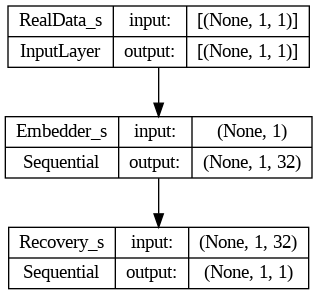

In [ ]:
plot_model(autoencoder_s,
           to_file=(results_path / 'autoencoder_s.png').as_posix(),
           show_shapes=True)

### Embedding Layer (Temporal Data)

In [ ]:
H_t = embedder_t(X_t)
X_tilde_t = recovery_t(H_t)

autoencoder_t = Model(inputs=X_t,
                    outputs=X_tilde_t,
                    name='Autoencoder_t')

In [ ]:
autoencoder_t.summary()

Model: "Autoencoder_t"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData_t (InputLayer)     [(None, 8, 70)]           0         
                                                                 
 Embedder_t (Sequential)     (None, 8, 64)             80192     
                                                                 
 Recovery_t (Sequential)     (None, 8, 38)             77350     
                                                                 
Total params: 157,542
Trainable params: 157,542
Non-trainable params: 0
_________________________________________________________________


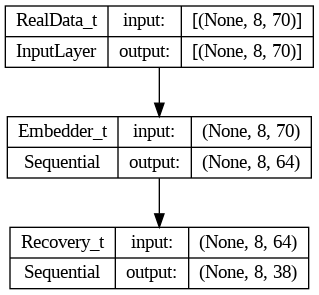

In [ ]:
plot_model(autoencoder_t,
           to_file=(results_path / 'autoencoder_t.png').as_posix(),
           show_shapes=True)

### Optimizers

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam as AdamLegacy

autoencoder_t_optimizer = AdamLegacy()
autoencoder_s_optimizer = AdamLegacy()

In [ ]:
@tf.function
def train_autoencoder_s_init(xs):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder_s(xs)
        embedding_loss_t0 = mse(xs, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder_s.trainable_variables + recovery_s.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_t_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

In [ ]:
@tf.function
def train_autoencoder_t_init(xs, xt):
    with tf.GradientTape() as tape:
        h_s = embedder_s(xs)
        x_tilde_s = recovery_s(h_s)
        x_tilde = autoencoder_t(tf.concat((xt, tf.broadcast_to(h_s, shape = (batch_size, seq_len, hidden_dim_s))), axis = 2))
        embedding_loss_t0_t = mse(xt, x_tilde)
        embedding_loss_t0_s = mse(xs, x_tilde_s)
        e_loss_0_t = 10 * tf.sqrt(embedding_loss_t0_t)
        e_loss_0_s = 10 * tf.sqrt(embedding_loss_t0_s)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0_t + embedding_loss_t0_s)

    var_list = autoencoder_t.trainable_variables + autoencoder_s.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)

    autoencoder_t_optimizer.apply_gradients(zip(gradients, var_list))

    return tf.sqrt(embedding_loss_t0_t)

In [ ]:
for step in tqdm(range(train_steps)):
    xs, xt = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_s_init(xs)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder (s) Init', step_e_loss_t0, step=step)

100%|██████████| 20000/20000 [01:12<00:00, 277.69it/s]


In [ ]:
autoencoder_s.save(log_dir / 'autoencoder_s')

In [ ]:
for step in tqdm(range(train_steps)):
    xs, xt = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_t_init(xs, xt)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder (t) Init', step_e_loss_t0, step=step)

100%|██████████| 20000/20000 [03:38<00:00, 91.40it/s] 


In [ ]:
autoencoder_t.save(log_dir / 'autoencoder_s')

## Phase 2 : Train Supervisor

### Optimizer

In [ ]:
supervisor_optimizer = AdamLegacy()

In [ ]:
@tf.function
def train_supervisor(xs, xt):
    with tf.GradientTape() as tape:
        H_s = embedder_s(xs)
        H_t = embedder_t(tf.concat((xt, tf.broadcast_to(H_s, shape = (batch_size, seq_len, hidden_dim_s))), axis = 2))
        h_hat_supervised = supervisor(H_t)
        g_loss_s = mse(H_t[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In [ ]:
for step in tqdm(range(train_steps)):
    xs, xt = next(real_series_iter)
    step_g_loss_s = train_supervisor(xs, xt)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 20000/20000 [02:06<00:00, 158.58it/s]


In [ ]:
supervisor.save(log_dir / 'supervisor')

## Joint Training

### Generator

### Adversarial Architecture - Supervised

In [ ]:
E_s_hat = generator_s(Z_s)
E_t_hat = generator_t(tf.concat((Z_t, tf.broadcast_to(E_s_hat, shape = (batch_size, seq_len, hidden_dim_s))), axis = 2))
H_hat = supervisor(E_t_hat)
Y_fake = discriminator(H_hat)

### Adversarial Architecture in Latent Space

In [ ]:
Y_fake_e = discriminator(E_t_hat)

### Mean and Variance Loss

In [ ]:
X_t_hat = recovery_t(H_hat)
X_s_hat = Z_s

In [ ]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture - Real Data

In [ ]:
Y_real = discriminator(H_hat)

## Optimizers

In [ ]:
generator_s_optimizer = AdamLegacy()
generator_t_optimizer = AdamLegacy()
discriminator_optimizer = AdamLegacy()
embedding_optimizer = AdamLegacy()

## Generator Train Step

In [ ]:
@tf.function
def train_generator(x_s, x_t, z_s, z_t):
  with tf.GradientTape() as tape:
    e_s_hat = generator_s(z_s)
    e_t_hat = generator_t(tf.concat((z_t, tf.broadcast_to(e_s_hat, shape = (batch_size, seq_len, hidden_dim_s))), axis = 2))
    h_hat = supervisor(e_t_hat)
    y_fake = discriminator(h_hat)

    generator_loss_unsupervised = bce(y_true = tf.ones_like(y_fake),
                                      y_pred = y_fake)

    y_fake_e = discriminator(e_t_hat)
    generator_loss_unsupervised_e = bce(y_true = tf.ones_like(y_fake_e),
                                        y_pred = y_fake_e)

    h_s = embedder_s(x_s)
    h_t = embedder_t(tf.concat((x_t, tf.broadcast_to(h_s, shape = (batch_size, seq_len, hidden_dim_s))), axis = 2))
    h_hat_supervised = supervisor(h_t)
    generator_loss_supervised = mse(h_t[:, 1:, :], h_hat_supervised[:, 1:, :])



    x_t_hat = recovery_t(h_hat)
    generator_moment_loss = get_generator_moment_loss(x_t, x_t_hat)

    generator_loss = (generator_loss_unsupervised +
                      generator_loss_unsupervised_e +
                      100 * tf.sqrt(generator_loss_supervised) +
                      100 * generator_moment_loss)

  var_list = generator_s.trainable_variables + generator_t.trainable_variables + supervisor.trainable_variables
  gradients = tape.gradient(generator_loss, var_list)
  generator_t_optimizer.apply_gradients(zip(gradients, var_list))
  return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss


## Embedding Train Step

In [ ]:
@tf.function
def train_embedder(x_s, x_t):
  with tf.GradientTape() as tape:
    h_s = embedder_s(x_s)
    h_t = embedder_t(tf.concat((x_t, tf.broadcast_to(h_s, shape = (batch_size, seq_len, hidden_dim_s))), axis = 2))
    h_hat_supervised = supervisor(h_t)
    generator_loss_supervised = mse(h_t[:, 1:, :], h_hat_supervised[:, 1:, :])

    x_tilde = recovery_t(h_t)
    x_s_tilde = recovery_s(h_s)
    embedding_loss_t0_t = mse(x_t, x_tilde)
    embedding_loss_t0_s = mse(x_s, x_s_tilde)

    e_loss = 10 * (embedding_loss_t0_t + embedding_loss_t0_s) + 0.1 * generator_loss_supervised

  var_list = embedder_t.trainable_variables + recovery_t.trainable_variables + embedder_s.trainable_variables + recovery_s.trainable_variables
  gradients = tape.gradient(e_loss, var_list)
  embedding_optimizer.apply_gradients(zip(gradients, var_list))
  return tf.sqrt(embedding_loss_t0_t + embedding_loss_t0_s)

## Discriminator Train Step

In [ ]:
@tf.function
def get_discriminator_loss(x_s, x_t, z_s, z_t):
  e_xs = embedder_s(x_s)
  e_xt = embedder_t(tf.concat((x_t, tf.broadcast_to(e_xs, shape = (batch_size, seq_len, hidden_dim_s))), axis = 2))
  h_x = supervisor(e_xt)
  y_real = discriminator(h_x)
  discriminator_loss_real = bce(y_true = tf.ones_like(y_real),
                                y_pred = y_real)

  e_zs = generator_s(z_s)
  e_zt = generator_t(tf.concat((z_t, tf.broadcast_to(e_zs, shape = (batch_size, seq_len, hidden_dim_s))), axis = 2))
  h_hat = supervisor(e_zt)
  y_fake = discriminator(h_hat)
  discriminator_loss_fake = bce(y_true = tf.zeros_like(y_fake),
                                y_pred = y_fake)


  y_fake_e = discriminator(h_hat)
  discriminator_loss_fake_e  = bce(y_true = tf.zeros_like(y_fake_e),
                                   y_pred = y_fake_e)

  return (discriminator_loss_real + discriminator_loss_fake + gamma * discriminator_loss_fake_e)

In [ ]:
@tf.function
def train_discriminator(x_s, x_t, z_s, z_t):
  with tf.GradientTape() as tape:
    discriminator_loss = get_discriminator_loss(x_s, x_t, z_s, z_t)

  var_list = discriminator.trainable_variables
  gradients = tape.gradient(discriminator_loss, var_list)
  discriminator_optimizer.apply_gradients(zip(gradients, var_list))
  return discriminator_loss

## Training Loop

In [ ]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        xs, xt = next(real_series_iter)
        zs, zt = next(random_series_s), next(random_series_t)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(xs, xt, zs, zt)
        # Train embedder
        step_e_loss_t0 = train_embedder(xs, xt)

    xs, xt = next(real_series_iter)
    zs, zt = next(random_series_s), next(random_series_t)
    step_d_loss = get_discriminator_loss(xs, xt, zs, zt)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(xs, xt, zs, zt)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 1.9671 | g_loss_u: 0.8427 | g_loss_s: 0.0020 | g_loss_v: 0.1525 | e_loss_t0: 4.4332
 1,000 | d_loss: 1.9362 | g_loss_u: 1.1261 | g_loss_s: 0.0001 | g_loss_v: 0.0274 | e_loss_t0: 3.9577
 2,000 | d_loss: 1.6580 | g_loss_u: 1.6908 | g_loss_s: 0.0001 | g_loss_v: 0.0356 | e_loss_t0: 3.7968
 3,000 | d_loss: 1.3638 | g_loss_u: 2.0559 | g_loss_s: 0.0001 | g_loss_v: 0.0387 | e_loss_t0: 3.9662
 4,000 | d_loss: 1.3187 | g_loss_u: 2.1317 | g_loss_s: 0.0001 | g_loss_v: 0.0386 | e_loss_t0: 3.9434
 5,000 | d_loss: 1.3302 | g_loss_u: 1.7799 | g_loss_s: 0.0001 | g_loss_v: 0.0318 | e_loss_t0: 3.8904
 6,000 | d_loss: 1.4774 | g_loss_u: 1.7871 | g_loss_s: 0.0001 | g_loss_v: 0.0385 | e_loss_t0: 3.8219
 7,000 | d_loss: 1.4560 | g_loss_u: 1.8306 | g_loss_s: 0.0001 | g_loss_v: 0.0359 | e_loss_t0: 4.4859
 8,000 | d_loss: 1.1732 | g_loss_u: 2.0707 | g_loss_s: 0.0001 | g_loss_v: 0.0261 | e_loss_t0: 3.9930
 9,000 | d_loss: 1.2461 | g_loss_u: 2.1435 | g_loss_s: 0.0001 | g_loss_v: 0.0431 | e_loss_t

## Save Model

In [ ]:
generator_s.save(log_dir / 'generator_s')
generator_t.save(log_dir / 'generator_t')
supervisor.save(log_dir / 'supervisor')
discriminator.save(log_dir / 'discriminator')
embedder_s.save(log_dir / 'embedder_s')
embedder_t.save(log_dir / 'embedder_t')
recovery_s.save(log_dir / 'recovery_s')
recovery_t.save(log_dir / 'recovery_t')

# Generate Synthetic Data

## Specify Industry

In [ ]:
def make_random_data_S(industry = 0):
  while True:
    if industry:
      yield(np.array([industry])).reshape((1, -1)).astype(np.float32)
    else:
      yield(np.random.choice(industry_cat)).reshape((1, -1))

## Generate Random Walk for Temporal Variables

In [ ]:
def make_random_data_T():
    while True:
        yield (np.random.normal(loc=0.0, scale=1.0, size=(seq_len, n_seq)))

## Convert Random Vectors to Tensors

In [ ]:
random_series_s = iter(tf.data.Dataset
                       .from_generator(make_random_data_S, output_types = tf.float32)
                       .batch(batch_size)
                       .repeat())

In [ ]:
random_series_t = iter(tf.data.Dataset
                     .from_generator(make_random_data_T, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

## Synthetic Data Generator

In [ ]:
def get_synthetic_data(batch_multiples = 800):
  generated_data = []
  for i in range(batch_multiples):
    zs, zt = next(random_series_s), next(random_series_t)
    e_s_hat = generator_s(zs)
    e_t_hat = generator_t(tf.concat((zt, tf.broadcast_to(e_s_hat, shape = (batch_size, seq_len, hidden_dim_s))), axis = 2))
    h_hat = supervisor(e_t_hat)
    d = recovery_t(h_hat)
    generated_data.append(d)
  return generated_data

## Convert to NumPy Array

In [ ]:
generated_data = get_synthetic_data()
generated_data = np.array(np.vstack(generated_data))
np.save(log_dir / 'generated_data_0.npy', generated_data)
generated_data.shape

## Re-scale synthetic data

In [ ]:
generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))
generated_data.shape

## Save Synthetic Data

In [ ]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq),
                                             columns=df.columns[:-1]))